In [2]:
import numpy as np
from math import exp,log,sqrt,pi,tanh
import matplotlib.pyplot as plt
from numba import cuda

# Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [3]:
from numba import vectorize, float64

@vectorize([float64(float64)])
def vec_log(x):
    return log(x)

@vectorize([float64(float64)])
def vec_exp(x):
    return exp(x)

A = [2, 5, 10, 3, 8]
print(vec_log(A))
print(vec_exp(A))

[0.69314718 1.60943791 2.30258509 1.09861229 2.07944154]
[7.38905610e+00 1.48413159e+02 2.20264658e+04 2.00855369e+01
 2.98095799e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

In [9]:
@vectorize([float64(float64)])
def Gaussian(x):
    sigma = 1.
    mean  = 1.
    return 1/sqrt(2*pi*sigma**2) * exp(-(x-mean)**2 /(2*sigma**2))

x = np.linspace(-3, 3, num=100000, endpoint=True)

print(Gaussian(x))

[0.00013383 0.00013386 0.00013389 ... 0.05400393 0.05399745 0.05399097]


## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

Text(0.5, 1.0, 'Waveform after suppresion')

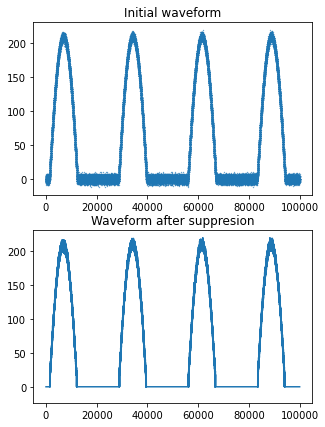

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)

@vectorize([float64(float64)])
def supp_zero(x):
    if x>15: return x
    else: return 0

fig, axs = plt.subplots(2,figsize=(5,7),sharey=True)
axs[0].plot(data,'.',markersize=0.6)
axs[0].set_title('Initial waveform')

axs[1].plot(supp_zero(data))
axs[1].set_title('Waveform after suppresion')


##### Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [29]:
from numba import jit
import math
X = np.random.rand(3,3)
Y = np.random.rand(3,3)

@vectorize
def vec_tanh(arg):
    return math.tanh(arg)
@jit
def sigmoidKernel(x,y,alpha,c):
    arg = np.dot(alpha*x.T,y)+c 
    return vec_tanh(arg)

k = sigmoidKernel(X,Y,1,4)
print(k)

[[0.99973315 0.99985282 0.9998061 ]
 [0.99986033 0.99993504 0.99991761]
 [0.99980553 0.99985776 0.99986384]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [ ]:
# CUDA kernel
@cuda.jit
def cos_kernel_3D(v):
    row, col, l = cuda.grid(3)
    if row < v.shape[0] and col < v.shape[1] and l < v.shape[2]:
        # do the computation
        v[row][col][l] *= math.cos(v[row][col][l]) 

# 256𝑋256𝑋256 matrix:
x = np.random.normal(size=(256,256,256))

# Configure the blocks, CUDA'S doc
threadsperblock = (16, 16)
blockspergrid_x = int(math.ceil(x.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(x.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

#calculating the 𝑐𝑜𝑠 for each element of x
cos_kernel_3D[blockspergrid, threadsperblock](x)

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [ ]:
from __future__ import division
from numba import cuda
import numpy
import math

# complete the code
@cuda.jit
def matmul(A, B, C):
    """Perform matrix multiplication of C = A * B
    """
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.randint(22, size=(24,12))
B = np.random.randint(22, size=(24,12))

# Configure the blocks
threadsperblock = (16, 16)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

C = np.zeros((24,12))
matmul[blockspergrid, threadsperblock](A, B, C)

print(C)
